In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

 99% 1.75G/1.76G [00:19<00:00, 156MB/s]
100% 1.76G/1.76G [00:19<00:00, 97.1MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import os
import cv2
import time
import glob
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

modules loaded


In [ ]:
import shutil
import os

source_folder ='/tmp/lung_colon_image_set/colon_image_sets/colon_n'   # Path folder sumber
destination_folder = '/tmp/colon_lung'  # Direktori tujuan

# Menggabungkan jalur tujuan dengan nama folder sumber
destination_path = os.path.join(destination_folder, os.path.basename(source_folder))

# Menyalin folder dan kontennya ke direktori tujuan
shutil.copytree(source_folder, destination_path)


'/tmp/colon_lung/colon_n'

In [ ]:
data_dir = '/tmp/colon_lung'

In [ ]:
# Split The Data
# Fseries=>Files=>Filepaths
# Lseries=>Classes=>Lables
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(data_dir):

    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    strat=df['labels']
    train_df, dummy_df=train_test_split(df,  train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    strat = dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df,  train_size=0.5, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df

In [ ]:
train_df, valid_df, test_df = create_df(data_dir)

In [ ]:
# Data Preprocessing
# Data Generator with Data Augmentaion
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
def scalar(img):
    return img
tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
# base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
base_model.summary()
model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

In [ ]:
batch_size = 200
hist = model.fit(train_gen,
                 steps_per_epoch=train_gen.samples//batch_size,
                 validation_data=valid_gen,
                 validation_steps=valid_gen.samples//batch_size,
                 epochs=5)

Epoch 1/5
100/100 [==============================] - 1404s 14s/step - loss: 6.6997 - accuracy: 0.9035 - val_loss: 5.5963 - val_accuracy: 0.9000
Epoch 2/5
100/100 [==============================] - 1355s 14s/step - loss: 4.3415 - accuracy: 0.9672 - val_loss: 3.6102 - val_accuracy: 0.9833
Epoch 3/5
100/100 [==============================] - 1344s 13s/step - loss: 2.9888 - accuracy: 0.9783 - val_loss: 2.4373 - val_accuracy: 0.9896
Epoch 4/5
100/100 [==============================] - 1355s 14s/step - loss: 2.0896 - accuracy: 0.9833 - val_loss: 1.7061 - val_accuracy: 0.9937
Epoch 5/5
100/100 [==============================] - 1341s 13s/step - loss: 1.4646 - accuracy: 0.9893 - val_loss: 1.1919 - val_accuracy: 0.9958


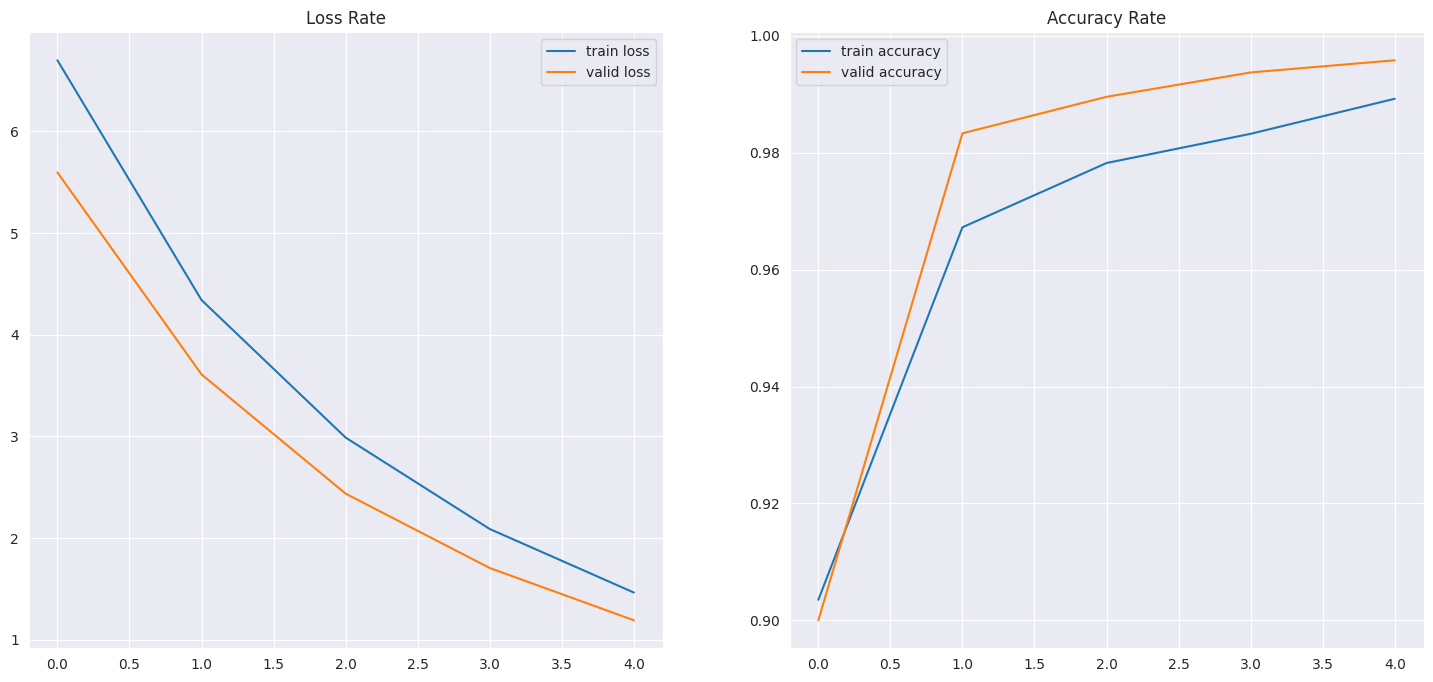

In [ ]:
# Accuracy and Loss
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'],label='train loss')
plt.plot(hist.history['val_loss'],label='valid loss')
plt.title('Loss Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'],label='train accuracy')
plt.plot(hist.history['val_accuracy'],label='valid accuracy')
plt.title('Accuracy Rate')
plt.legend()

plt.show()

In [ ]:
# Model Evaluation
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 [==============================] - 206s 4s/step - loss: 1.1805 - accuracy: 0.9960
Train Loss:  1.1759470701217651
Train Accuracy:  0.998449981212616
--------------------
Validation Loss:  1.1810775995254517
Validation Accuracy:  0.9983999729156494
--------------------
Test Loss:  1.1805065870285034
Test Accuracy:  0.9959999918937683


In [ ]:
# Prediction
batch_size = 200
target_names = ['Colon Adenocarcinoma', 'Colon Benign Tissue', 'Lung Adenocarcinoma','Lung Benign Tissue','Lung Squamous Cell Carcinoma']
Y_pred = model.predict_generator(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

<ipython-input-19-cfa72a912801>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen)


[4 0 3 ... 2 4 3]


In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap = plt.cm.Blues):
  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix, Without Normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color = 'white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[500   0   0   0   0]
 [  0 500   0   0   0]
 [  0   0 493   0   7]
 [  0   0   0 500   0]
 [  0   0   3   0 497]]


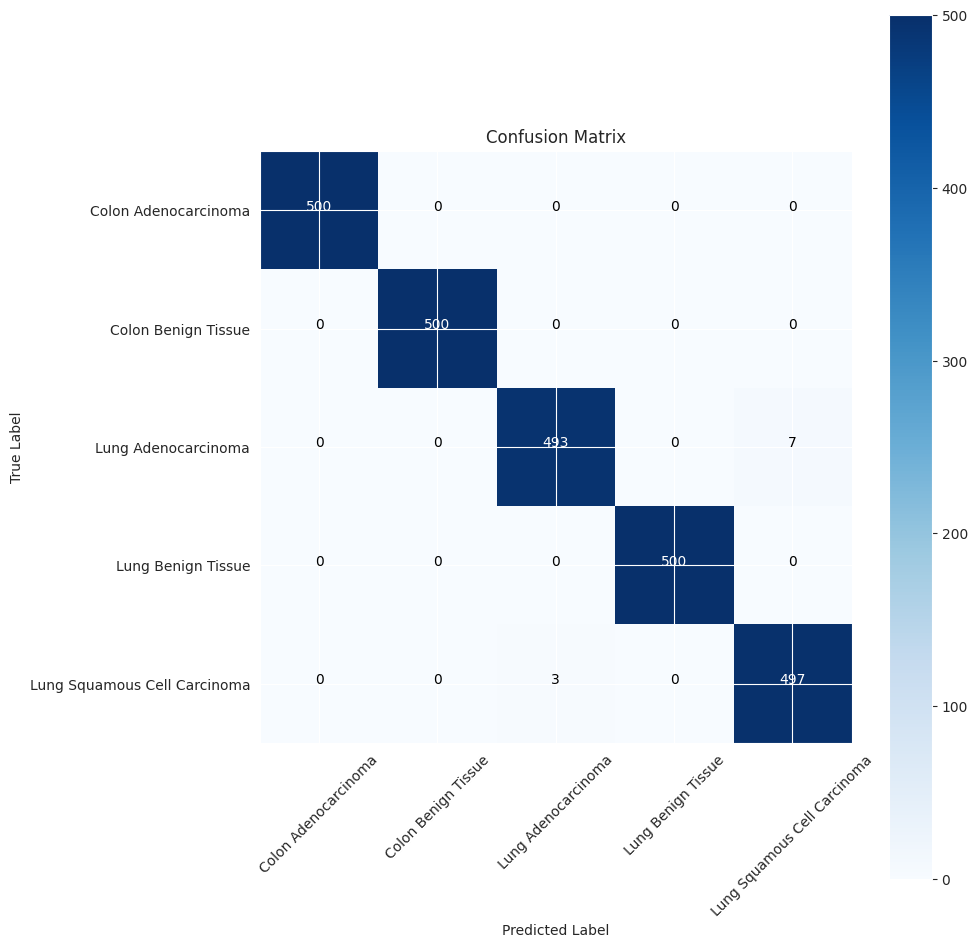

In [ ]:
plot_confusion_matrix(cm=cm, classes=target_names, title = 'Confusion Matrix')

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       500
         Colon Benign Tissue       1.00      1.00      1.00       500
         Lung Adenocarcinoma       0.99      0.99      0.99       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.99      0.99      0.99       500

                    accuracy                           1.00      2500
                   macro avg       1.00      1.00      1.00      2500
                weighted avg       1.00      1.00      1.00      2500



In [ ]:
#Save the model
model.save('Efficientb3-Lung Cancer.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
